In [1]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
%run ./matplotlib_fig_settings.py
np.seterr(under = 'ignore')
from time import time
from munch import munchify

Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


In [4]:
"""
## multi T mutli U data
from FKMC.import_funcs import get_data_funcmap, mean_over_MCMC, IPRandDOS, extract
def load_local(path): 
    p = Path(path).expanduser()
    return get_data_funcmap(p,
                functions = [IPRandDOS(E_bins = np.linspace(-20, 20, 10000 + 1)), 
                             mean_over_MCMC('Mf_moments'),
                            ],
                structure_names = ('repeats',),
                structure_dims = (None,),
               )

logger = logging.getLogger('FKMC.import_funcs')
logger.setLevel(logging.INFO) 

raw_data = dict()
"""

In [3]:
"""
from multiprocessing import Pool
runs = [
    #f"~/HPC_data/local_run_data/run_5_T=1.5",
    f"~/HPC_data/local_run_data/run_8_T=1.5_U=5",
    f"~/HPC_data/local_run_data/run_9_T=2.5_U=5",
]

#doesn't work I think because the returned object is too big
#with Pool(6) as p:
#    raw_data_list = p.map(load_local, runs)

raw_data_list = map(load_local, runs)

for i, path, d in zip(count(), runs, raw_data_list):
    raw_data[i] = munchify(d)
    print(f"path: {path}, structure_dims: {raw_data[i].structure_dims}")

print('done!')

p = Path('~/HPC_data/pickled_data/local_runs_processed.pickle').expanduser()
with open(p, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(raw_data, f, pickle.HIGHEST_PROTOCOL)
    print('Pickling Successful')
"""

looking in /rds/general/user/tch14/home/HPC_data/local_run_data/run_8_T=1.5_U=5


FileNotFoundError: [Errno 2] No such file or directory: '/rds/general/user/tch14/home/HPC_data/local_run_data/run_8_T=1.5_U=5'

In [2]:
from munch import munchify
from FKMC.general import smooth, spread
from scipy.stats import sem


def interpolate_IPR(E_bins, unsmoothed_DOS, IPR, dIPR):
    newshape = (IPR.size // IPR.shape[-1], IPR.shape[-1])
    _DOS = unsmoothed_DOS.reshape(newshape)
    _IPR = IPR.reshape(newshape)
    _dIPR = dIPR.reshape(newshape)
    
    for i, DOS, I, dI in zip(count(), _DOS, _IPR, _dIPR):
        ei = DOS > 0
        if any(ei):
            _I = I[ei]
            _dI = dI[ei]
            xI = E_bins[1:][ei]

            _IPR[i] = np.interp(E_bins[1:], xI, _I)
            _dIPR[i] = np.interp(E_bins[1:], xI, _dI)
        else:
            _IPR[i] = E_bins[1:] * np.NaN
            _dIPR[i] = E_bins[1:] * np.NaN

def prepare_data(o):
    o.energy_histogram_bins = o.E_bins

    interpolate_IPR(o.E_bins, unsmoothed_DOS=o.DOS, IPR=o.IPR, dIPR=o.dIPR)

    mean_axis = (1,) #mean out the repeat and starting states axes
    sem_axis = 1
    
    #use the indepedant repeats to estimate the errors
    o.DOS, o.dDOS = o.DOS.mean(axis = mean_axis), sem(o.DOS, axis = sem_axis)
    o.IPR, o.dIPR = o.IPR.mean(axis = mean_axis), sem(o.IPR, axis = sem_axis)

    print('\nShape of o.DOS after mean')
    print(o.DOS.shape)
    o.hints.DOS = np.delete(o.hints.DOS, mean_axis)
    print(o.hints.DOS)

    #('Ns', 'Ts', 'energy index')

    #smooth them
    for i, N in zip(count(), o.Ns):
        scale = 0.1
        o.DOS[i] = smooth(o.DOS[i], scale)
        o.IPR[i] = smooth(o.IPR[i], scale)

        o.dDOS[i] = smooth(o.dDOS[i], scale)
        o.dIPR[i] = smooth(o.dIPR[i], scale)
    return o
    
p = Path('~/HPC_data/pickled_data/local_runs_processed.pickle').expanduser()
with open(p, 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    raw_data = pickle.load(f)
    print('Unpickling Successful')
    
data = dict()    
for name, o in raw_data.items():
    o = munchify(o)
    print(f'steps per file = {o.MCMC_params.N_steps}, thin = {o.MCMC_params.thin}')
    print(f'Doing {name}, T={1 / o.parameters.beta}, U={o.parameters.U}, J={o.parameters.J}')
    print(f'Ns = {o.Ns}')
    data[name] = prepare_data(o)
    
p = Path('~/HPC_data/pickled_data/local_runs_processed_smoothed_june2.pickle').expanduser()
with open(p, 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    print('Pickling Successful')    

print('Done')

FileNotFoundError: [Errno 2] No such file or directory: '/rds/general/user/tch14/home/HPC_data/pickled_data/local_runs_processed.pickle'

In [ ]:
from customcolors import colors, colors10

o1, o2 = data.values()

linewidth = 0.5
xlim = (0, 0.9)
legend_fontsize = 5
legend_wspace = 0.01
legend_labelspacing = 0.63
wspace = 0
hspace = 0

f = plt.figure(constrained_layout=False)
gs = f.add_gridspec(2, 3, width_ratios=[1, 1, 0.4], wspace = wspace, hspace = hspace)

axes = np.array([
    [f.add_subplot(gs[0, 0]), f.add_subplot(gs[1, 0])],
    [f.add_subplot(gs[0, 1]), f.add_subplot(gs[1, 1])],
       ])
legend_axis = f.add_subplot(gs[:, 2], visible = False)

for ax in axes:
    ax[0].tick_params(axis = 'x', bottom = False, labelbottom = False)
    ax[1].tick_params(axis = 'x', top = False, labeltop = False)
    
axes[1,0].tick_params(axis = 'y', left = False, labelleft = False)
axes[1,1].tick_params(axis = 'y', left = False, labelleft = False)
axes[0,0].tick_params(axis = 'y', right = False, labelright = False)
axes[0,1].tick_params(axis = 'y', right = False, labelright = False)

lines = [None for _ in o1.Ns]
o = o1
print(f"Ns = {o.Ns}")
for i,N in list(enumerate(o.Ns))[::-1]:
    for o, col in zip([o1, o2], axes):
        E = np.where(o.DOS[i] > 0.01, o.DOS[i], np.NaN)
        I = np.where(o.DOS[i] > 0.01, o.IPR[i], np.NaN)
        lines[i], = col[0].plot(o.E_bins[1:] / o.parameters.U, E, label = f'N = {N}', color = colors10[i], linewidth = linewidth) 
        col[1].plot(o.E_bins[1:] / o.parameters.U, I, color = colors10[i], linewidth = linewidth)
    
    
for a in axes.flatten(): a.set(xlim = xlim)
    
axes[0,0].set(ylabel = 'DOS($\omega$)', yticks = [0, 0.5], yticklabels = ['0', '.5'])
axes[0,1].set(ylabel = 'IPR($\omega$)', xlabel = '$\omega$/U', yticks = [0, 0.1], yticklabels = ['0', '.1'])
axes[1,1].set(xlabel = '$\omega$/U')

#axes[0].legend()

for a in axes.flatten(): a.tick_params(direction = "in")
  
for label, ax in zip([f"(a) T = {1 / o1.parameters.beta}",
                      "(b)",
                      f"(c) T = {1 / o2.parameters.beta}",
                      "(d)"],
                     axes.flatten()):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', color = 'black')
    
from matplotlib.legend import Legend

#get the x position of the right of the plots in figure coords
_, (x0, _) = axes[1,0].get_position().get_points()
#get the y position of the bottom of the plots in figure coords
(_, y0), _ = axes[1,1].get_position().get_points()
#get the top right of the legend axis
_, (x1, y1) = legend_axis.get_position().get_points()


rect = mpl.patches.Rectangle((x0+legend_wspace,y0),x1-x0-legend_wspace,y1-y0,
                             linewidth=0.7,
                             edgecolor='k',
                             facecolor='none',
                             transform = f.transFigure)
f.add_artist(rect)

leg = f.legend(
             handles = lines, 
             labels = [f"{N}" for N in o.Ns],
             frameon=True,
             fontsize = legend_fontsize,
             loc = 'center',
             bbox_to_anchor=rect.get_bbox(),
            labelspacing = legend_labelspacing,
           fancybox = False,
           bbox_transform=f.transFigure,
)
#modify the frame of the legend
frame = leg.get_frame()
frame.set(visible = False)

#change the title of the legend
leg.set_title("N =  ... ", prop = dict(size = legend_fontsize))

#add the legend to the figure
f.add_artist(leg);

f.subplots_adjust()
f.set_size_inches(10,5)

In [ ]:
p = Path(f'~/HPC_data/pickled_data/local_runs_processed_smoothed_june2.pickle').expanduser()
with open(p, 'rb') as file: 
    data = pickle.load(file)
    print(data.keys())

In [25]:
#%%time
from FKMC.import_funcs import incremental_load, extract, mean_over_MCMC, IPRandDOS, extractStates

functions = [
    mean_over_MCMC('Mf_moments', N_error_bins = 10),
    IPRandDOS(),
    extractStates(),
]
oU5 = incremental_load(folder = '~/HPC_data/IPR_DOR_U5_J5_above_below_Tc', functions = functions, 
                       force_reload = True,
                      loglevel = logging.DEBUG)

def prepare_data(o):
    o.energy_histogram_bins = o.E_bins

    interpolate_IPR(o.E_bins, unsmoothed_DOS=o.DOS, IPR=o.IPR, dIPR=o.dIPR)

    #smooth them
    for i, N in zip(count(), o.Ns):
        scale = 0.1
        o.DOS[i] = smooth(o.DOS[i], scale)
        o.IPR[i] = smooth(o.IPR[i], scale)
    return o

prepare_data(oU5)
None

INFO:FKMC.import_funcs:looking in /rds/general/user/tch14/home/HPC_data/IPR_DOR_U5_J5_above_below_Tc


[PosixPath('/rds/general/user/tch14/home/HPC_data/IPR_DOR_U5_J5_above_below_Tc/code/single.py')]


DEBUG:FKMC.import_funcs:structure_names = ['Ts']
DEBUG:FKMC.import_funcs:structure_dims = (4,)
DEBUG:FKMC.import_funcs:Missing jobs, should all be up to 9
DEBUG:FKMC.import_funcs:task_id: chain_ids
INFO:FKMC.import_funcs:Expected number of tasks 4
INFO:FKMC.import_funcs:Measured number of tasks 4
INFO:FKMC.import_funcs:Expected number of chains None
INFO:FKMC.import_funcs:Shortest Chain 10
INFO:FKMC.import_funcs:Longest Chain 10
INFO:FKMC.import_funcs:Using chain length 10


Ham_params:  t=1, alpha=1.25, mu=0, beta=varying, J=5, U=5, normalise=True,


Tasks per chain: 10,

Each doing 10000 steps,

100000 total chain length,

1000 samples,


MCMC_params:  N_steps=10000, N_burn_in=10000, thin=100, proposal=<function p_multi_site_uniform_reflect at 0x2acede387dd0>, accept_function=<function perturbation_accept at 0x2acede3c7f80>, warnings=False,


INFO:FKMC.import_funcs:Logger keys: ['A', 'Fc', 'Ff', 'IPRs', 'Mf_moments', 'N_cumulants', 'N_sites', 'N_steps', 'Nc', 'Nf', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'accept_rates', 'classical_accept_rates', 'eigenval_bins', 'eigenvals', 'last_state', 'powers', 'proposal_rates', 'return_vals', 'start', 'state', 'time', 'update'] 

INFO:FKMC.import_funcs:MCMC_params keys: ['N_steps', 'N_burn_in', 'thin', 'proposal', 'accept_function', 'warnings', 'state', 'logger'] 

INFO:FKMC.import_funcs:Overall steps = 1000
DEBUG:FKMC.import_funcs:[(0, 'Ts', 4)]
DEBUG:FKMC.import_funcs:available observables = ['A', 'Fc', 'Ff', 'IPRs', 'Mf_moments', 'N_cumulants', 'N_sites', 'N_steps', '

0 1 2 

INFO:FKMC.import_funcs:########################################################################

INFO:FKMC.import_funcs:Observables has keys: dict_keys(['functions', 'flat', 'hints', 'processed_task_ids', 'this_run', 'datapath', 'codepath', 'py_script', 'batch_params', 'structure_names', 'structure_dims', 'N_tasks', 'chains', 'N_chains', 'original_N_steps', 'thin', 'N_steps', 'max_MC_step', 'E_bins', 'Ns', 'parameters', 'MCMC_params', 'structure_dimensions', 'chain_id', 'task_id', 'allow_pickle', 'desc', 'Ts', 'Mf_moments', 'DOS', 'IPR', 'dDOS', 'dIPR', 'state', 'time', 'accept_rates', 'proposal_rates'])
INFO:FKMC.import_funcs:    Completed jobs:?
    MCMC Steps: 10 chains of 10000 for 100000 with thinning = 100 for 1000 recorded steps
    Burn in: 10000
    Structure_names: {'Ts': 4}
    Ns = [ 70  80  90 110 130 150 180 210 250 300]
    Runtimes: 
        Average: 1.0 days
        Min: 15.0 hours
        Max: 4.0 days
        Total: 6.0 days
    


3 

((4, 1000, 300),
 ('Ns', 'Ts', 'MCMC_step', 'N'),
 array([[0.75, 0.5 , 0.5 , ..., 0.5 , 0.25, 0.5 ],
        [1.  , 0.25, 1.  , ..., 0.25, 1.  , 0.25],
        [0.25, 0.5 , 0.25, ..., 0.5 , 0.  , 0.5 ],
        ...,
        [0.5 , 1.  , 0.5 , ..., 0.75, 0.25, 0.5 ],
        [0.  , 0.75, 0.25, ..., 0.25, 0.5 , 0.25],
        [0.75, 0.  , 0.75, ..., 0.  , 1.  , 0.  ]]))

In [1]:
from scipy.stats import sem
from FKMC.import_funcs import incremental_load, mean_over_MCMC, IPRandDOS, interpolate_IPR, extract
from FKMC.general import smooth

functions = [
    mean_over_MCMC('Mf_moments', N_error_bins = 10),
    IPRandDOS(),
    extract('states'),
]
os = incremental_load(folder = '~/HPC_data/individual_IPRs', functions = functions, force_reload = False)

def prepare_data(o):
    o.energy_histogram_bins = o.E_bins

    interpolate_IPR(o.E_bins, unsmoothed_DOS=o.DOS, IPR=o.IPR, dIPR=o.dIPR)
    
    o.dDOS = sem(o.DOS, axis = 1)
    o.dIPR = sem(o.IPR, axis = 1)
    o.DOS = o.DOS.mean(axis = 1)
    o.IPR = o.IPR.mean(axis = 1)

    
    #smooth them
    for i, N in zip(count(), o.Ns):
        scale = 0.5
        o.DOS[i] = smooth(o.DOS[i], scale)
        o.IPR[i] = smooth(o.IPR[i], scale)
        o.dDOS[i] = smooth(o.dDOS[i], scale)
        o.dIPR[i] = smooth(o.dIPR[i], scale)
    return o

prepare_data(os)

    
p = Path('~/HPC_data/pickled_data/individual_IPRs.pickle').expanduser()
with open(p, 'wb') as f:
    pickle.dump(os, f, pickle.HIGHEST_PROTOCOL)
    print('Pickling Successful')  
    
os.hints, os.dDOS.shape

DEBUG:FKMC.import_funcs:todo: []
INFO:FKMC.import_funcs:########################################################################

INFO:FKMC.import_funcs:Observables has keys: dict_keys(['flat', 'hints', 'processed_task_ids', 'this_run', 'datapath', 'codepath', 'py_script', 'batch_params', 'structure_names', 'structure_dims', 'N_tasks', 'chains', 'N_chains', 'original_N_steps', 'thin', 'N_steps', 'E_bins', 'Ns', 'parameters', 'MCMC_params', 'structure_dimensions', 'chain_id', 'task_id', 'allow_pickle', 'desc', 'Rs', 'Us', 'Ts', 'Mf_moments', 'DOS', 'IPR', 'dDOS', 'dIPR', 'time', 'accept_rates', 'proposal_rates', 'functions'])
INFO:FKMC.import_funcs:    Completed jobs:?
    MCMC Steps: 5 chains of 1000 for 5000 with thinning = 10 for 500 recorded steps
    Burn in: 1000
    Structure_names: {'Rs': 10, 'Us': 2, 'Ts': 2}
    Ns = [ 40  60  70  80 100 120 150 180 220 270]
    Runtimes: 
        Average: 5.0 hours
        Min: 2.0 hours
        Max: 12.0 hours
        Total: 1.0 weeks
    
 

NameError: name 'count' is not defined

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


tau = 0.06+/-0.01 0.06(1)
tau = 0.02+/-0.01 0.02(1)
tau = 0.05+/-0.03 0.05(3)
tau = 0.30+/-0.03 0.30(3)
tau = 0.04+/-0.02 0.04(2)
tau = 0.00+/-0.01 0.001(9)
tau = 0.06+/-0.04 0.06(4)
tau = 0.15+/-0.05 0.15(5)


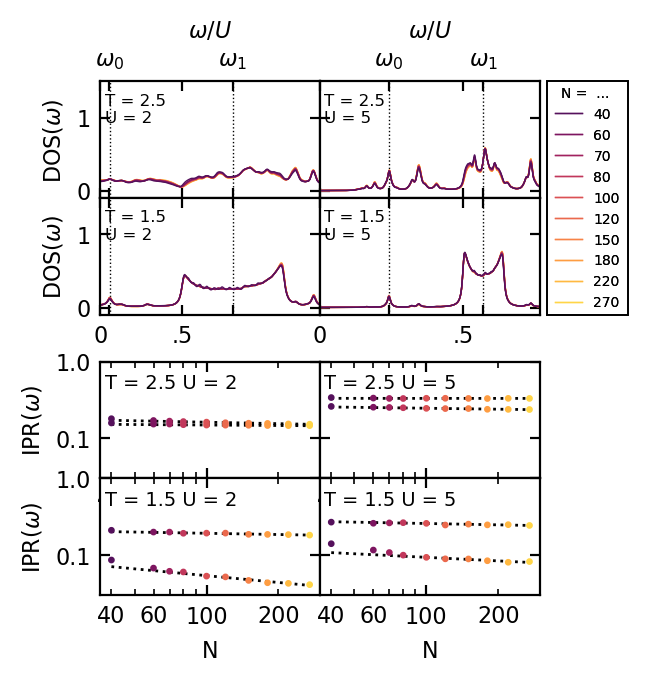

In [30]:
DOSxlim = np.array([0, 1.2])
DOSylim = (-0.1,1.5)

IPRylim = (0.03, 0.3)
Es = [
    lambda o: 1/16 * 0.9 if o.parameters.U == 2 else 1/4 * 0.96,
    lambda o: 1/4 * (1 + np.sqrt(1 + 16/o.parameters.U**2)),
     ]

linewidth = 0.5
legend_fontsize = 5
legend_wspace = 0.01
legend_labelspacing = 0.5
wspace = 0
hspace = 0



from FKMC.general import get_nearby_index
from customcolors import colors, colors10

def pulloutbytemp_and_U(o, T_i, U_i):
    newo = o.copy()
    newo.DOS = newo.DOS[:, U_i, T_i]
    newo.IPR = newo.IPR[:, U_i, T_i]
    newo.dDOS = newo.dDOS[:, U_i, T_i]
    newo.dIPR = newo.dIPR[:, U_i, T_i]
    newo.parameters.beta = 1 / o.Ts[T_i]
    newo.parameters.U = o.Us[U_i]
    return newo


def plot_DOS(ax, o):
    DOS = np.where(o.DOS > 0.001, o.DOS, np.NaN)
    lines = [None for _ in o.Ns]
    for i, N in list(enumerate(o.Ns))[::-1]:
        lines[i], = ax.plot(o.E_bins[1:] / o.parameters.U, DOS[i], label = f'N = {N}', color = colors10[i], linewidth = linewidth) 
        
    xlim = 1/2 * np.sqrt(1 + 16/o.parameters.U**2) * DOSxlim
    ax.set(xlim = xlim, ylim = DOSylim)
    
    #do the arrows showing where the IPRs are taken
    for e in Es: 
        true_E, E_i = get_nearby_index(o.E_bins[1:] / o.parameters.U, e(o))
        x, y = (true_E, max(o.DOS[:, E_i]))
        ax.vlines(x, ax.get_ylim()[0], ax.get_ylim()[1], colors='k', linestyles='dotted', linewidth = linewidth)

    label = f"T = {1 / o.parameters.beta}\nU = {o.parameters.U}"
    ax.text(0.02, 0.9, label, transform=ax.transAxes,
            fontsize=6, fontweight='normal', va='top', color = 'black')
    
    return lines

def plot_IPR_scaling(ax, o):
    lines = [None for _ in Es]
    for i, e in enumerate(Es): 
        true_E, E_i = get_nearby_index(o.E_bins[1:] / o.parameters.U, e(o))
        IvN = np.array([o.IPR[i, E_i] for i, _ in enumerate(o.Ns)])
        dIvN = np.array([o.dIPR[i, E_i] for i, _ in enumerate(o.Ns)])

        #model is IPR(N) = A * N ^ (-tau)
        def IPR(N, A, tau): return A * N ** (-tau)
        idx = o.Ns > 70
        (A, tau), pcov = scipy.optimize.curve_fit(IPR, o.Ns[idx], IvN[idx], p0=(0.5, 0.5), sigma=dIvN[idx], absolute_sigma=True)
        dA, dtau = np.sqrt(np.diag(pcov))
        
        #lines[i], = ax.plot(o.Ns, IvN, linewidth = linewidth)
        ax.plot(o.Ns, IPR(o.Ns, A, tau), linestyle = 'dotted', color = 'k', marker = None, linewidth = linewidth*2)
        #ax.errorbar(o.Ns, IvN, yerr = dIvN, fmt = 'none', ecolor = 'k',
        #            elinewidth = linewidth / 2, capsize = 1, capthick = linewidth / 2)
        ax.scatter(o.Ns, IvN, c = colors10, s = 2, zorder = 3)
        
        def errorfmt(a, da):
            digit = -int(np.floor(np.log10(da)))
            d = f'{da:.1g}'[-1]
            return f'{a:.{digit}f}({d})'
        
        print(f'tau = {tau:.2f}+/-{dtau:.2f} {errorfmt(tau, dtau)}')
        
        
        ax.set(
               yscale = 'log', 
               xscale = 'log',
               ylim = IPRylim,
              )
        
    label = f"T = {1 / o.parameters.beta} U = {o.parameters.U}"
    ax.text(0.02, 0.9, label, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', color = 'black')
    return lines

f = plt.figure(constrained_layout=False)

#make a split between the top and bottom
gs = f.add_gridspec(ncols = 1, nrows = 2, hspace = 0.2)
groups = [None, None]
legend_axes = [None, None]

for i in range(2):
    sgs = gs[i].subgridspec(nrows = 2, ncols = 3, 
                                      width_ratios=[1, 1, 0.4],
                                      hspace = 0,
                                      wspace = 0,
                                     )
    groups[i] = np.array([
                 [f.add_subplot(sgs[0, 0]), f.add_subplot(sgs[1, 0])],
                 [f.add_subplot(sgs[0, 1]), f.add_subplot(sgs[1, 1])],
                ])
           
    legend_axes[i] = f.add_subplot(sgs[:, 2], visible = False)


for U_i, col in enumerate(groups[0]):
    for T_i, ax in zip([1,0], col):
        o = pulloutbytemp_and_U(os, T_i = T_i, U_i = U_i)
        lines = plot_DOS(ax, o)
        
        ax.set(xticks = [0, 0.5] + [e(o) for e in Es],)
        
        if T_i == 1: #set the omega labels for the top of the DOS plot
            ax.tick_params(bottom = True, labelbottom = False, top = True, labeltop = True)
            ax.set(xticklabels = ['', ''] + [f'$\omega_{i}$' for i, _ in enumerate(Es)],
                  xlabel = '$\omega / U$',
                  )
            ax.xaxis.set_label_position('top')
            
        if T_i == 0: #set the numerical xlabels for the bottom of the DOS plot
            ax.tick_params(top = True, labeltop = False, labelbottom = True)
            ax.set(
            xticklabels = ['0', '.5'] + ['', '']
            )
            
        if U_i == 0: ax.set(ylabel = 'DOS($\omega$)')
        
        
        
for U_i, col in enumerate(groups[1]):
    for T_i, ax in zip([1,0], col):
        o = pulloutbytemp_and_U(os, T_i = T_i, U_i = U_i)
        omega_lines = plot_IPR_scaling(ax, o)
        
        ax.set(yticks = [0.1, 1])
        
        if U_i == 0: ax.set(ylabel = 'IPR($\omega$)')
        if T_i == 0: ax.set(xlabel = 'N')
            
        from matplotlib.ticker import StrMethodFormatter, NullFormatter
        ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}') if U_i == 0 else NullFormatter())
        ax.yaxis.set_minor_formatter(NullFormatter())
        
        ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
        #ax.xaxis.set_minor_formatter(StrMethodFormatter('{x:.0f}'))
        
        import matplotlib.ticker as ticker
        ax.xaxis.set_minor_formatter(ticker.FuncFormatter(
            lambda x,pos: f"{x:.0f}" if x in [40.0, 60.0, 200.0] else ''
        ))

#turn off the yticks labels for the right column
for g in groups: 
    for a in g[1, :]:
        a.tick_params(axis = 'y', labelleft = False)
        
#turn off the x ticks labels for the upper rows:
for g in groups: 
    for a in g[:, 0]:
        a.tick_params(axis = 'x', labelbottom = False)

    

    
def add_side_legend(axes, legend_axis, lines, labels):
    from matplotlib.legend import Legend
    #get the x position of the right of the plots in figure coords
    _, (x0, _) = axes[1,0].get_position().get_points()
    #get the y position of the bottom of the plots in figure coords
    (_, y0), _ = axes[1,1].get_position().get_points()
    #get the top right of the legend axis
    _, (x1, y1) = legend_axis.get_position().get_points()


    rect = mpl.patches.Rectangle((x0+legend_wspace,y0),x1-x0-legend_wspace,y1-y0,
                                 linewidth=0.7,
                                 edgecolor='k',
                                 facecolor='none',
                                 transform = f.transFigure)
    f.add_artist(rect)

    leg = f.legend(
                 handles = lines, 
                 labels = labels,
                 frameon=True,
                 fontsize = legend_fontsize,
                 loc = 'center',
                 bbox_to_anchor=rect.get_bbox(),
                labelspacing = legend_labelspacing,
               fancybox = False,
               bbox_transform=f.transFigure,
    )
    #modify the frame of the legend
    frame = leg.get_frame()
    frame.set(visible = False)
    
    f.add_artist(leg);
    return leg
    
leg = add_side_legend(axes = groups[0], legend_axis = legend_axes[0], lines=lines, 
                      labels = [f"{N}" for N in o.Ns])
leg.set_title("N =  ... ", prop = dict(size = legend_fontsize))

#leg = add_side_legend(axes = groups[1], legend_axis = legend_axes[1], lines=omega_lines, 
#                      labels = [f"$\omega_{i}$" for i,e in enumerate(Es)])

f.subplots_adjust()
f.set_size_inches(columnwidth, columnwidth)

In [112]:
a = 0.034
da = 0.05

def errorfmt(a, da):
    digit = -int(np.floor(np.log10(da)))
    d = f'{da:.1g}'[-1]
    print(digit, d)
    return f'{a:.{digit}f}({d})'

errorfmt(a, da)

2 5


'0.03(5)'

Ns = [ 40  60  70  80 100 120 150 180 220 270]


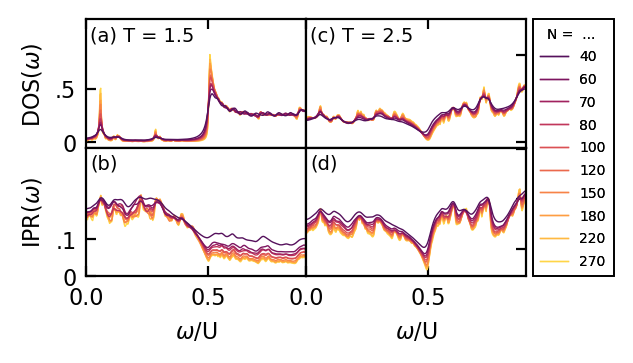

In [17]:
from customcolors import colors, colors10

def pulloutbytemp_and_U(o, T_i, U_i):
    newo = o.copy()
    newo.DOS = newo.DOS[:, U_i, T_i]
    newo.IPR = newo.IPR[:, U_i, T_i]
    newo.parameters.beta = 1 / o.Ts[T_i]
    newo.parameters.U = o.Us[U_i]
    return newo
    
U_i = 0
o1, o2 = pulloutbytemp_and_U(os, T_i = 0, U_i = U_i), pulloutbytemp_and_U(os, T_i = 1, U_i = U_i)


linewidth = 0.5
xlim = (0, 0.9)
legend_fontsize = 5
legend_wspace = 0.01
legend_labelspacing = 0.63
wspace = 0
hspace = 0

f = plt.figure(constrained_layout=False)
gs = f.add_gridspec(2, 3, width_ratios=[1, 1, 0.4], wspace = wspace, hspace = hspace)

axes = np.array([
    [f.add_subplot(gs[0, 0]), f.add_subplot(gs[1, 0])],
    [f.add_subplot(gs[0, 1]), f.add_subplot(gs[1, 1])],
       ])
legend_axis = f.add_subplot(gs[:, 2], visible = False)

for ax in axes:
    ax[0].tick_params(axis = 'x', bottom = False, labelbottom = False)
    ax[1].tick_params(axis = 'x', top = False, labeltop = False)
    
axes[1,0].tick_params(axis = 'y', left = False, labelleft = False)
axes[1,1].tick_params(axis = 'y', left = False, labelleft = False)
axes[0,0].tick_params(axis = 'y', right = False, labelright = False)
axes[0,1].tick_params(axis = 'y', right = False, labelright = False)

lines = [None for _ in o1.Ns]
o = o1
print(f"Ns = {o.Ns}")
for i,N in list(enumerate(o.Ns))[::-1]:
    for o, col in zip([o1, o2], axes):
        E = np.where(o.DOS[i] > 0.001, o.DOS[i], np.NaN)
        I = np.where(o.DOS[i] > 0.001, o.IPR[i], np.NaN)
        lines[i], = col[0].plot(o.E_bins[1:] / o.parameters.U, E, label = f'N = {N}', color = colors10[i], linewidth = linewidth) 
        col[1].plot(o.E_bins[1:] / o.parameters.U, I, color = colors10[i], linewidth = linewidth)
    
    
for a in axes.flatten(): a.set(xlim = xlim)
    
axes[0,0].set(ylabel = 'DOS($\omega$)', yticks = [0, 0.5], yticklabels = ['0', '.5'])
axes[0,1].set(ylabel = 'IPR($\omega$)', xlabel = '$\omega$/U', yticks = [0, 0.1], yticklabels = ['0', '.1'])
axes[1,1].set(xlabel = '$\omega$/U')

#axes[0].legend()

for a in axes.flatten(): a.tick_params(direction = "in")
  
for label, ax in zip([f"(a) T = {1 / o1.parameters.beta}",
                      "(b)",
                      f"(c) T = {1 / o2.parameters.beta}",
                      "(d)"],
                     axes.flatten()):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', color = 'black')
    
from matplotlib.legend import Legend

#get the x position of the right of the plots in figure coords
_, (x0, _) = axes[1,0].get_position().get_points()
#get the y position of the bottom of the plots in figure coords
(_, y0), _ = axes[1,1].get_position().get_points()
#get the top right of the legend axis
_, (x1, y1) = legend_axis.get_position().get_points()


rect = mpl.patches.Rectangle((x0+legend_wspace,y0),x1-x0-legend_wspace,y1-y0,
                             linewidth=0.7,
                             edgecolor='k',
                             facecolor='none',
                             transform = f.transFigure)
f.add_artist(rect)

leg = f.legend(
             handles = lines, 
             labels = [f"{N}" for N in o.Ns],
             frameon=True,
             fontsize = legend_fontsize,
             loc = 'center',
             bbox_to_anchor=rect.get_bbox(),
            labelspacing = legend_labelspacing,
           fancybox = False,
           bbox_transform=f.transFigure,
)
#modify the frame of the legend
frame = leg.get_frame()
frame.set(visible = False)

#change the title of the legend
leg.set_title("N =  ... ", prop = dict(size = legend_fontsize))

#add the legend to the figure
f.add_artist(leg);

f.subplots_adjust()
f.set_size_inches(columnwidth,columnwidth/2)

In [2]:
from customcolors import colors, colors10

def pulloutbytemp(o, i):
    newo = o.copy()
    newo.DOS = newo.DOS[:, i]
    newo.IPR = newo.IPR[:, i]
    newo.parameters.beta = 1 / o.Ts[i]
    return newo
    
o1, o2 = pulloutbytemp(oU5, 0), pulloutbytemp(oU5, 3)

linewidth = 0.5
xlim = (0, 0.9)
legend_fontsize = 5
legend_wspace = 0.01
legend_labelspacing = 0.63
wspace = 0
hspace = 0

f = plt.figure(constrained_layout=False)
gs = f.add_gridspec(2, 3, width_ratios=[1, 1, 0.4], wspace = wspace, hspace = hspace)

axes = np.array([
    [f.add_subplot(gs[0, 0]), f.add_subplot(gs[1, 0])],
    [f.add_subplot(gs[0, 1]), f.add_subplot(gs[1, 1])],
       ])
legend_axis = f.add_subplot(gs[:, 2], visible = False)

for ax in axes:
    ax[0].tick_params(axis = 'x', bottom = False, labelbottom = False)
    ax[1].tick_params(axis = 'x', top = False, labeltop = False)
    
axes[1,0].tick_params(axis = 'y', left = False, labelleft = False)
axes[1,1].tick_params(axis = 'y', left = False, labelleft = False)
axes[0,0].tick_params(axis = 'y', right = False, labelright = False)
axes[0,1].tick_params(axis = 'y', right = False, labelright = False)

lines = [None for _ in o1.Ns]
o = o1
print(f"Ns = {o.Ns}")
for i,N in list(enumerate(o.Ns))[::-1]:
    for o, col in zip([o1, o2], axes):
        E = np.where(o.DOS[i] > 0.001, o.DOS[i], np.NaN)
        I = np.where(o.DOS[i] > 0.001, o.IPR[i], np.NaN)
        lines[i], = col[0].plot(o.E_bins[1:] / o.parameters.U, E, label = f'N = {N}', color = colors10[i], linewidth = linewidth) 
        col[1].plot(o.E_bins[1:] / o.parameters.U, I, color = colors10[i], linewidth = linewidth)
    
    
for a in axes.flatten(): a.set(xlim = xlim)
    
axes[0,0].set(ylabel = 'DOS($\omega$)', yticks = [0, 0.5], yticklabels = ['0', '.5'])
axes[0,1].set(ylabel = 'IPR($\omega$)', xlabel = '$\omega$/U', yticks = [0, 0.1], yticklabels = ['0', '.1'])
axes[1,1].set(xlabel = '$\omega$/U')

#axes[0].legend()

for a in axes.flatten(): a.tick_params(direction = "in")
  
for label, ax in zip([f"(a) T = {1 / o1.parameters.beta}",
                      "(b)",
                      f"(c) T = {1 / o2.parameters.beta}",
                      "(d)"],
                     axes.flatten()):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', color = 'black')
    
from matplotlib.legend import Legend

#get the x position of the right of the plots in figure coords
_, (x0, _) = axes[1,0].get_position().get_points()
#get the y position of the bottom of the plots in figure coords
(_, y0), _ = axes[1,1].get_position().get_points()
#get the top right of the legend axis
_, (x1, y1) = legend_axis.get_position().get_points()


rect = mpl.patches.Rectangle((x0+legend_wspace,y0),x1-x0-legend_wspace,y1-y0,
                             linewidth=0.7,
                             edgecolor='k',
                             facecolor='none',
                             transform = f.transFigure)
f.add_artist(rect)

leg = f.legend(
             handles = lines, 
             labels = [f"{N}" for N in o.Ns],
             frameon=True,
             fontsize = legend_fontsize,
             loc = 'center',
             bbox_to_anchor=rect.get_bbox(),
            labelspacing = legend_labelspacing,
           fancybox = False,
           bbox_transform=f.transFigure,
)
#modify the frame of the legend
frame = leg.get_frame()
frame.set(visible = False)

#change the title of the legend
leg.set_title("N =  ... ", prop = dict(size = legend_fontsize))

#add the legend to the figure
f.add_artist(leg);

f.subplots_adjust()
f.set_size_inches(columnwidth,columnwidth/2)

NameError: name 'oU5' is not defined

In [ ]:
T_i = 1
print('T', oU5.Ts[T_i])

f, ax = plt.subplots()

for E_i in [1500, 1200]:
    e = oU5.E_bins[E_i] / oU5.parameters.U
    y = oU5.IPR[:, T_i, E_i] / oU5.IPR[0, T_i, E_i]
    
    ax.plot(oU5.Ns, y, label = f'E/U = {e}')
    ax.set(yscale = 'log', xscale = 'log', xlabel = "N", ylabel = 'IPR')
    
ax.legend()